## Retrievl Augmented Generation (RAG) with LLM

Here we are providing an example of RAG with Falcon-Instruct-7B LLM and FAISS semantic search using [Langchain](https://python.langchain.com/docs/get_started/introduction).

Most of the available RAG examples tend to use an API for either LLM (eg: [openai api](https://platform.openai.com/docs/api-reference)) or for vector database (eg: [pinecone](https://www.pinecone.io/)). Here in this example, we are *not* using any external APIs. Instead, we are hosting everything locally.

#### How does RAG work?
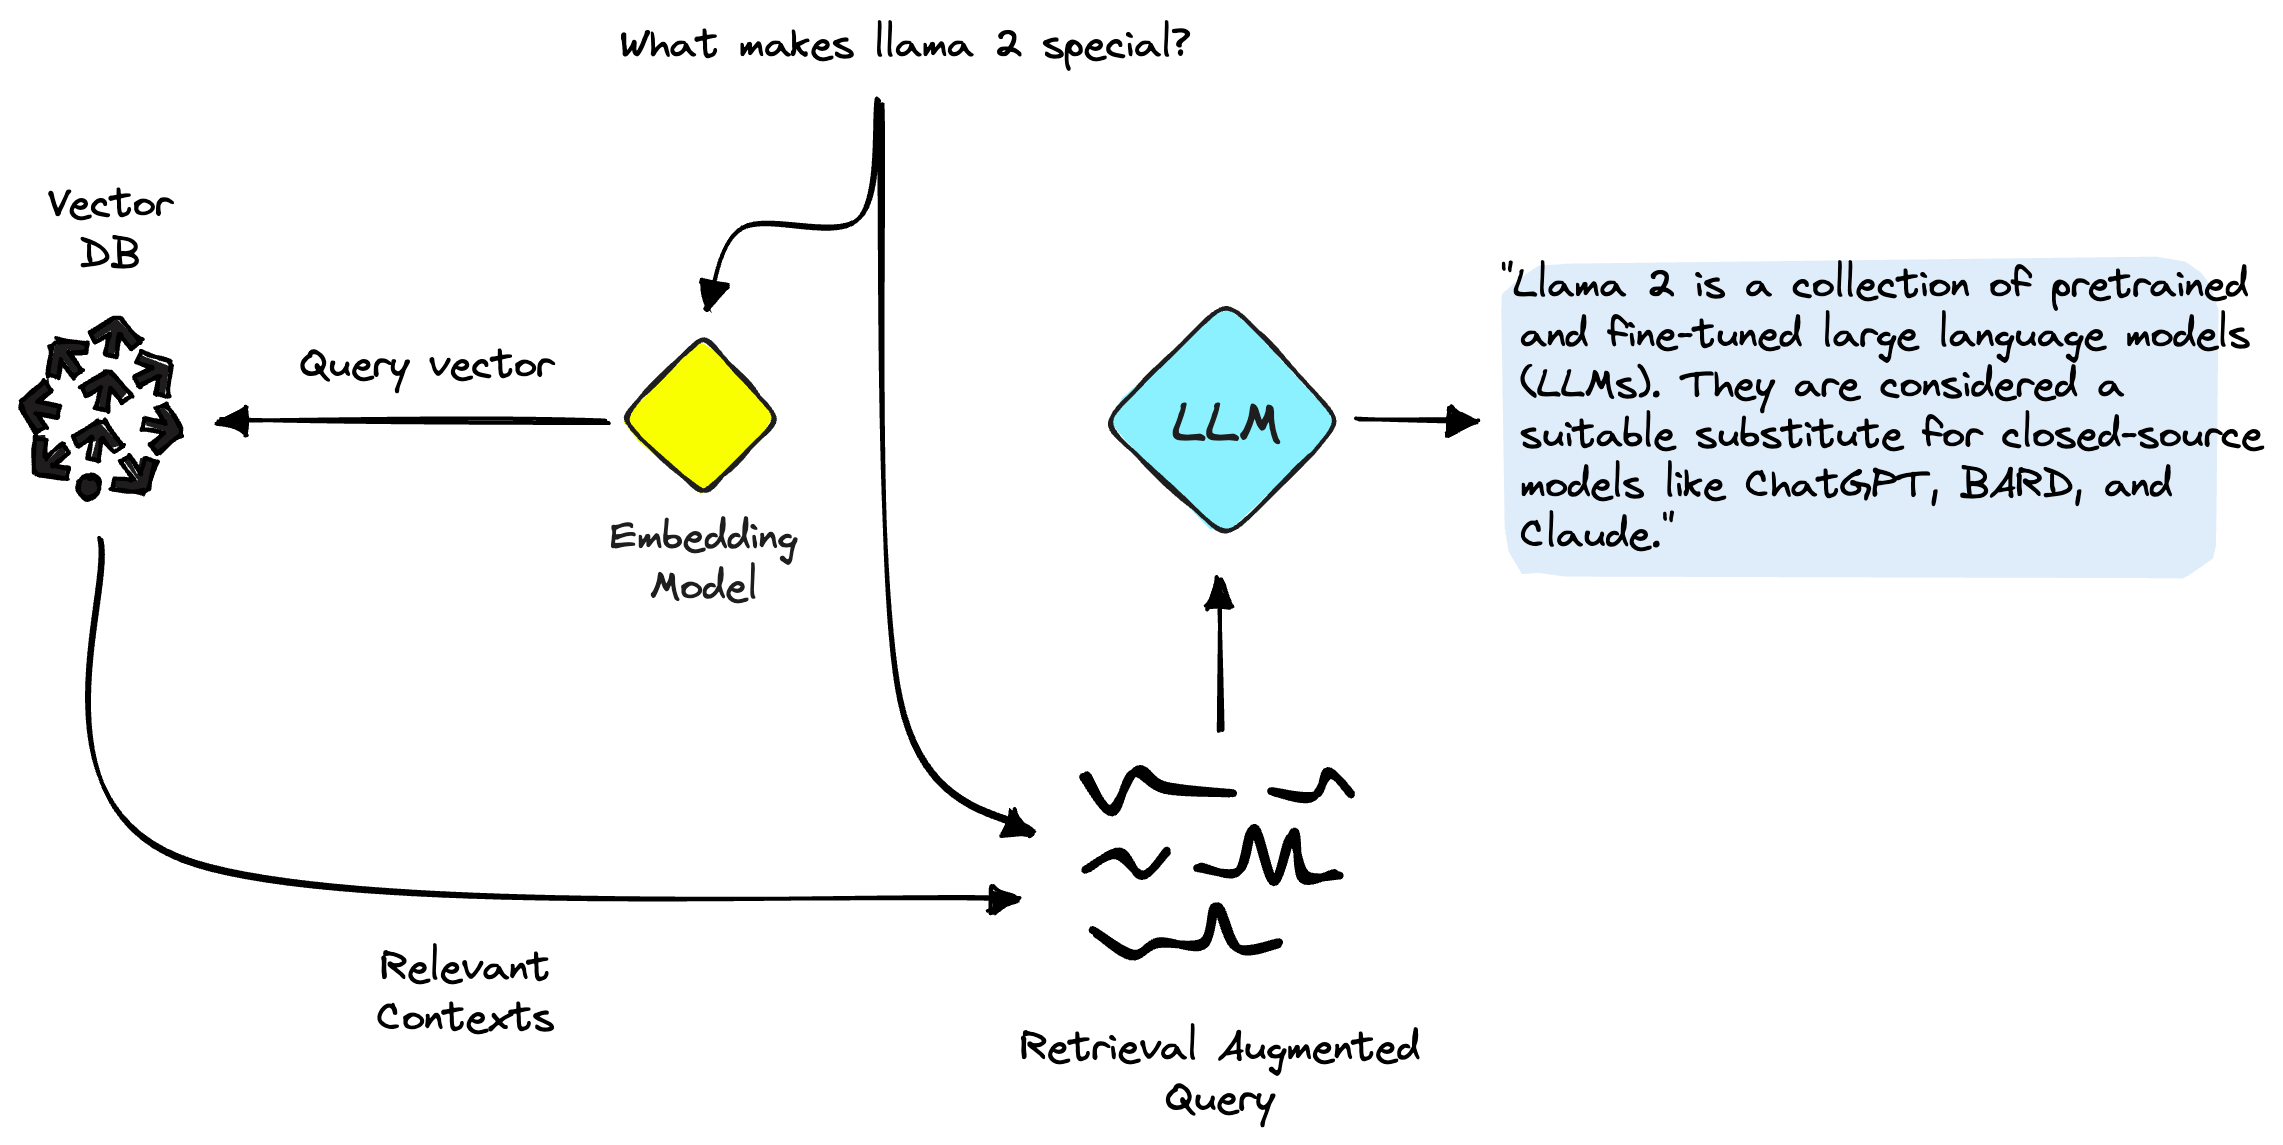

*[image source](https://www.pinecone.io/learn/fast-retrieval-augmented-generation/)*
#### Reference Lnks:
1. https://python.langchain.com/docs/expression_language/cookbook/retrieval
2. https://www.pinecone.io/learn/fast-retrieval-augmented-generation/
3. https://youtu.be/QMaWfbosR_E

Here is an example response to the following questions with respect to the Digital Catapult Employees Handbook document.

```python
question1 = "At Digital Catapult, how many days of annual leave is an employee entitled to?"

answer1 >>>

"An employee is entitled to 25 days' paid holiday in each holiday year in addition to the usual public holidays. The Company's annual leave year runs between 1 January and 31 December. If you commence or terminate employment part way through a holiday year, your annual leave entitlement during that holiday year will be calculated on a pro-rata basis rounded up to the nearest half day. If you work part-time, your annual leave entitlement will be pro-rated accordingly in line with your working"
```

```python
question2 = "At Digital Catapult, what is the maximum number of leave days employees are allowed to carry forward to the next year?"

answer2 >>>

"The maximum number of leave days employees are allowed to carry forward to the next year is 5 days."

```

In [ ]:
# # Additional dependencies to install if you are running for the first time

# !pip install pypdf langchain faiss-gpu
# !pip install sentence-transformers
# !pip install -U optimum

#### Imports

In [ ]:
from langchain.chains import RetrievalQA
from langchain.document_loaders import PyPDFLoader
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.llms import HuggingFacePipeline
from langchain.prompts import PromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS

from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, AutoModel

#### Loading the document to be searched oon

In [ ]:
# The smaple file used here is the pdf version of the wikipedia page of the
# 95th accedemy award winning movie 'Everything Everywhere All at Once'
# Accessed from - https://en.wikipedia.org/wiki/Everything_Everywhere_All_at_Once
pdf_path = "./files/sample_wiki_file.pdf"

In [ ]:
## Load the PDF file
pdfLoader = PyPDFLoader(pdf_path)
documents = pdfLoader.load()

In [ ]:
# # If you want to inspect the pdf document, uncomment this cell

# idx = 2
# documents[idx]

In [ ]:
chunk_size = 1000
chunk_overlap = 150
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size, chunk_overlap=chunk_overlap
)
docs = text_splitter.split_documents(documents)

#### Vector Encoding of the document

Encoding model used is [all-mpnet-base-v2](https://huggingface.co/sentence-transformers/all-mpnet-base-v2) from huggingface.

In [ ]:
embedding_model_name = "sentence-transformers/all-mpnet-base-v2"
encode_kwargs = {"normalize_embeddings": False}
embeddings = HuggingFaceEmbeddings(
    model_name=embedding_model_name, encode_kwargs=encode_kwargs
)

#### Using FAISS for indexing the encoded document for semantic context retrieval

In [ ]:
vector_db = FAISS.from_documents(docs, embeddings)

#### Loading the LLM Model

In [ ]:
gpu_id = "auto"

llm_model_name = "tiiuae/falcon-7b-instruct"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(llm_model_name)
model = AutoModelForCausalLM.from_pretrained(llm_model_name)
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device_map="auto",
    max_new_tokens=256,
    pad_token_id=tokenizer.eos_token_id,
    # temperature=0.0,  # Use temperature parameter only with do_sample=False
    # do_sample=True
    do_sample=False,  # Generates the greedy result
)
llm = HuggingFacePipeline(pipeline=pipe)

#### Creating a Langchain

In [ ]:
prompt_template_augment = """Use ONLY the following pieces of context to answer the question at the end.
If suffieient information is not available to answer the question,
respond with that information rather than making up an answer.
Keep the answer concise, short and to the point. 
Context: 
{context}
Question: {question}
Answer:"""

In [ ]:
augmented_prompt = PromptTemplate.from_template(prompt_template_augment)

In [ ]:
# # Uncomment the below line to see the structure of the augmented prompt
# print(augmented_prompt)

#### Questions

In [ ]:
# Feel free to experiment with your questions related to the document that you have uploaded

question1 = "Which movie got the oscar for best picture in 2023?"
question2 = "What is the total number of Oscar nominations received by 'Everything Everywhere All At Once'?"

#### Relevant context information retrieved from the input document related to the question

In [ ]:
# # Uncomment the below lines to see the relevant context information grabbed from the document
# searchDocs = vector_db.similarity_search(question1)
# print(searchDocs[0].page_content)

#### Answering queries - without RAG

If you want to see how the models respond if we didn't provide any contextual information via retrieval, 
uncomment the below two cells.

In [ ]:
result1 = llm(question1)
print(f"Query:\n\t{question1}")
print(f"\nResponse:\t{result1}")

In [ ]:
result2 = llm(question2)
print(f"Query:\n\t{question2}")
print(f"\nResponse:\t{result2}")

#### Answering queries - with RAG

In [ ]:
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vector_db.as_retriever(),
    chain_type_kwargs={"prompt": augmented_prompt},
)

In [ ]:
result1 = qa_chain({"query": question1})

print(f"Query:\n\t{question1}")
print(f"Response:\n\t{result1['result']}")

In [ ]:
result2 = qa_chain({"query": question2})

print(f"Query:\n\t{question2}")
print(f"\nResponse:\n\t{result2['result']}")

In [ ]:
question3 = "How many oscar nominations has the movie 'Everything Everywhere All At Once' received and how many it won?"

In [ ]:
result3 = qa_chain({"query": question3})

print(f"Query:\n\t{question3}")
print(f"\nResponse:\n\t{result3['result']}")